<a href="https://colab.research.google.com/github/ORIE5355/project_competition_public/blob/main/run_gym_headtohead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import time
from IPython import display

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import make_env

In [44]:
project_part = 1 #TODO Change this for whether you're coding for part 1 or part 2!
agentnames = ['dummy_at_pred', 'dummy_max_val']

In [50]:
if project_part == 2:
    env, agents = make_env.make_env_agents(agentnames = agentnames, project_part = project_part)
    
else:
    env, agents = make_env.make_env_agents(agentnames = agentnames, project_part = project_part
    , first_file = 'data/datafile1.csv', second_file='data/datafile2.csv')

# you can replace the agentnames to match whatever agentfiles you create. 
# you can use the same agentnames for both agents

In [51]:
T = 500
import time

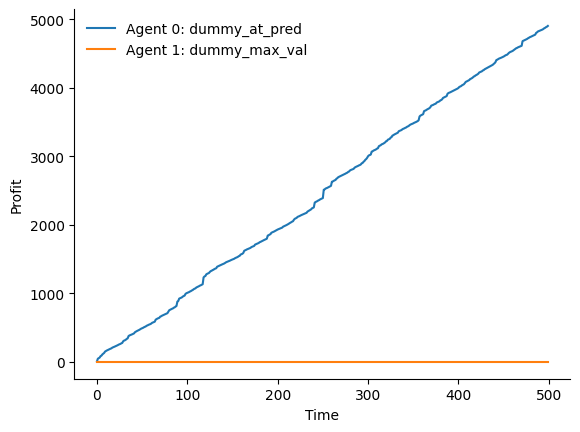

last customer covariate:  [11.130563247756761]
last (item bought, agent bought from, prices):  (0, 0, [[11.129563247756762], [9223372036854775807]])
current_profit per agent:  [4905.557623169584, 0]
Cumulative buyer utility: 0.500000000000079
Average per-customer runtime agent 0 in seconds: 5.365371704101563e-06
Average per-customer runtime agent 1 in seconds: 1.1656761169433594e-05


In [52]:
env.reset()
customer_covariates, sale, profits = env.get_current_state_customer_to_send_agents()
last_customer_covariates = customer_covariates
cumulativetimes = [0 for _ in agents]

fig, ax = plt.subplots(figsize=(20, 10))
for t in range(0, T):
    actions = []
    for enoutside, agent in enumerate(agents):
      ts = time.time()
      action = agent.action((customer_covariates, sale, profits))
      assert len(action) == project_part ## Have to give 1 price for each item. There is 1 item in part 1, 2 items in part 2
      curtime = time.time()
      cumulativetimes[enoutside] += curtime - ts
      actions.append(action)
    customer_covariates, sale, profits = env.step(actions)
    newplot = env.render(True)
    if newplot:
      display.clear_output(wait=True)
      display.display(plt.gcf())
    print('last customer covariate: ', last_customer_covariates)
    print('last (item bought, agent bought from, prices): ', sale)
    print('current_profit per agent: ', profits)
    last_customer_covariates = customer_covariates
plt.close()
print("Cumulative buyer utility: {}".format(env.cumulative_buyer_utility))
print("Average per-customer runtime agent 0 in seconds: {}".format(cumulativetimes[0]/T))
print("Average per-customer runtime agent 1 in seconds: {}".format(cumulativetimes[1]/T))